In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

D:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

n = 10

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.3).fit_sample(X_train, y_train)

### Feature Importance, как атрибут модели

Некоторые модели, такие как XGBoost, LGBMClassifier, RandomForestRegressor и др., имеют атрибут __feature\_importances\___, который показывает, насколько важен каждый из признаков. Эта "важность" может расчитываться как, например, путем суммирования прироста качества при разбиении узлов дерева по этому признаку, или же равняться количеству разбиений в дереве, которые произошли по данному признаку.

Посмотрим на примере XGBoost, как это выглядит.

Precision: 0.2948866457057753
Recall: 0.4296046287367406
F1: 0.34972034147777453
Log Loss: 0.13303924520158913
ROC AUC: 0.8991041185701452


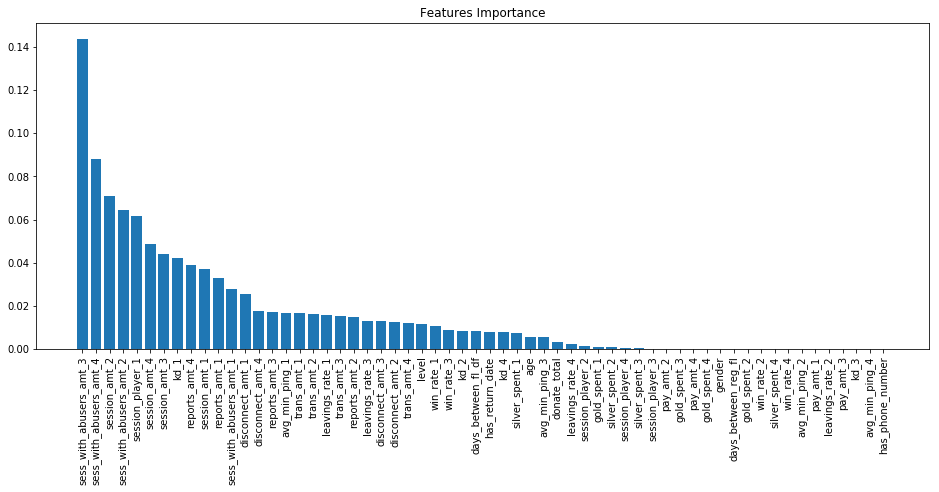

In [3]:
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance')

Попробуем обучить модель на Топ-30 признаках и оценить качество.

In [9]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.29152367879203844
Recall: 0.4095949855351977
F1: 0.34061748195669606
Log Loss: 0.13216987805057384
ROC AUC: 0.8963936396209413
Признаков было: 60
Признаков стало: 30


Видим, что кол-во признаков уменьшили __вдвое__, а качество практически не изменилось.

### Хи-квадрат

Данный способ позволяет отбирать признаки, используя статистический тест о зависимости между признаком и целевой переменной. Тест Хи-квадрат применяется в статистике для проверки независиости двух событий. Чем больше значение статистики Хи-квадрат, тем больше сильна завиимости между признаком и таргетом. Рассчитаем статистику и отберем признаки.

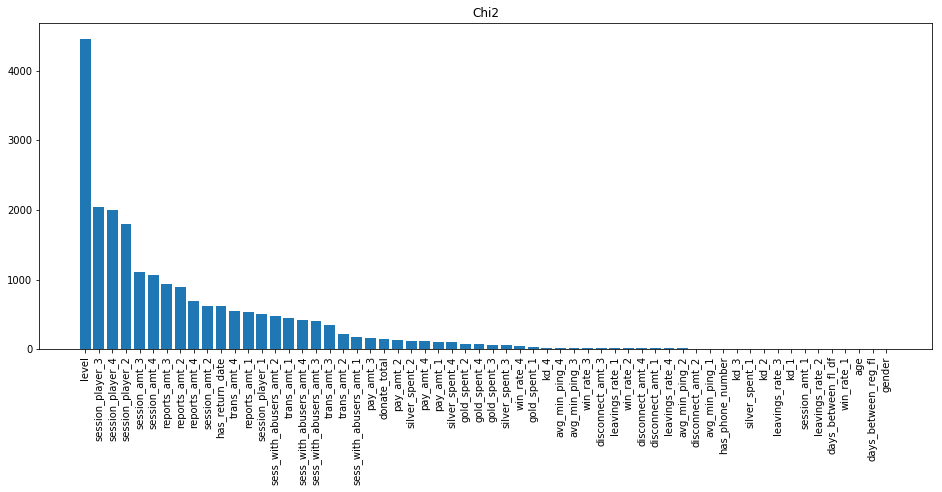

In [10]:
# Обратитевнимание, что значения в датасете должны быть неотрицательными для расчета Хи квартат
chi2_test = chi2(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(chi2_test[0], X.columns, 'Chi2')

Попробуем обучить модель на Топ-30 признаков и оценить качество.

In [11]:
X_train_CHI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_CHI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_CHI, y_train_balanced, X_test_CHI, y_test)

Precision: 0.28203445447087777
Recall: 0.4144165863066538
F1: 0.33564385433954896
Log Loss: 0.1491679286702777
ROC AUC: 0.8246239922106606


Видим, что на отобранных Хи-квадратом признаках качество упало сильнее, чем при отборе Feature Impotrance модели, но в целом так же незначительно.

### Взаимная информация

Отбор признаков на основании значения [взаимной информации](https://ru.wikipedia.org/wiki/%D0%92%D0%B7%D0%B0%D0%B8%D0%BC%D0%BD%D0%B0%D1%8F_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D1%8F).

In [12]:
mi = mutual_info_classif(X_train_balanced, y_train_balanced)

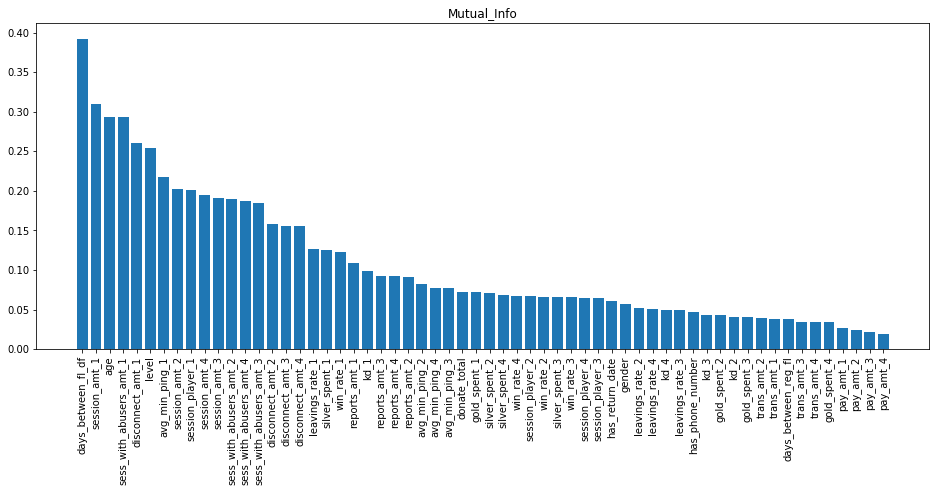

In [13]:
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [14]:
X_train_mi = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_mi = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_mi, y_train_balanced, X_test_mi, y_test)

Precision: 0.29186434721490073
Recall: 0.40043394406943106
F1: 0.33763593861164753
Log Loss: 0.13341707864382504
ROC AUC: 0.8947854182193264


### RFE (Recursive Feature Elimination)

Рекурскивный отсев признаков - убираем на каждой итерации самые слабые признаки и делаем это до тех пор, пока не увидим заметного снижения качества. На каком кол-ве признаков остановимся, то и считаем оптимальным.

In [15]:
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 40


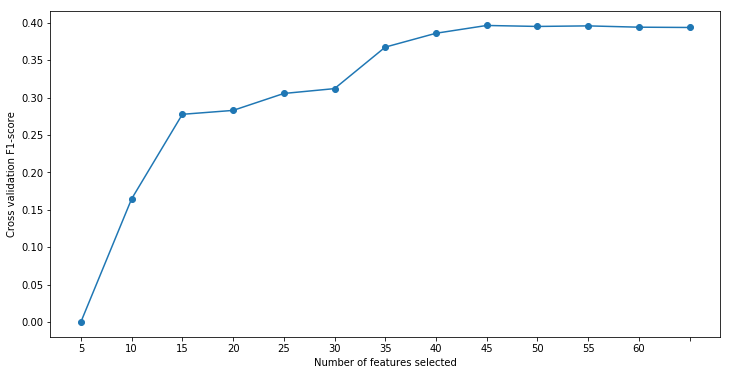

In [16]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

In [17]:
good_features

Index(['level', 'donate_total', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3',
       'trans_amt_4', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4',
       'reports_amt_1', 'reports_amt_2', 'reports_amt_4',
       'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2',
       'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4', 'session_amt_1',
       'session_amt_2', 'session_amt_3', 'session_amt_4', 'disconnect_amt_1',
       'disconnect_amt_4', 'avg_min_ping_1', 'avg_min_ping_3',
       'avg_min_ping_4', 'kd_1', 'kd_4', 'session_player_1',
       'session_player_2', 'session_player_3', 'leavings_rate_1', 'win_rate_1',
       'win_rate_4', 'silver_spent_1', 'silver_spent_2', 'silver_spent_3',
       'gold_spent_1', 'gold_spent_2', 'has_return_date'],
      dtype='object')

In [18]:
X_train_rfe = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_rfe = pd.DataFrame(X_test, columns=X.columns)[good_features]

In [19]:
fitted_clf = xgb_fit_predict(X_train_rfe, y_train_balanced, X_test_rfe, y_test)

Precision: 0.29101307189542486
Recall: 0.4293635486981678
F1: 0.3469029996104402
Log Loss: 0.13223245871109116
ROC AUC: 0.8998652838853916


### Permutation Importance (PI)

Перемешивание значений столбца важного признака приводит к заметному снижению качества работы модели

In [4]:
from eli5.sklearn import PermutationImportance

In [5]:
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

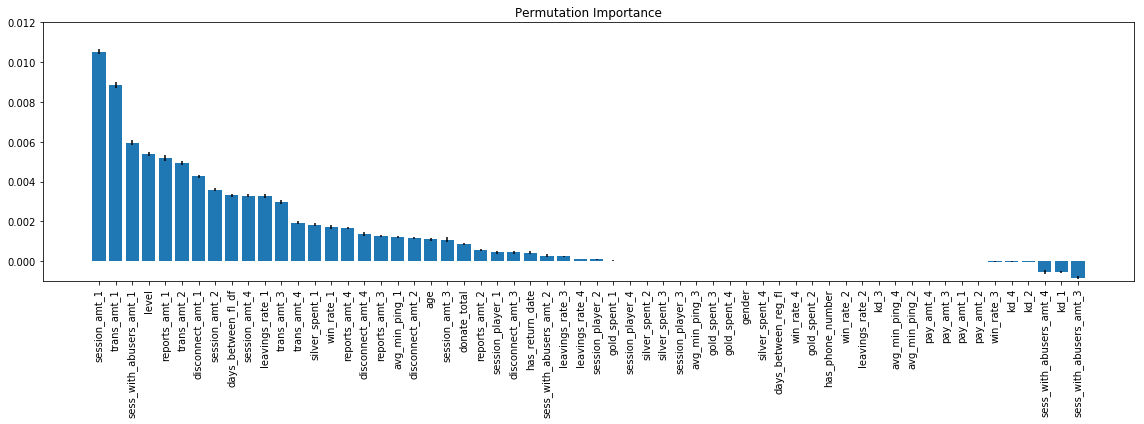

In [6]:
plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.ylim(-0.001,0.012)
plt.show()

In [7]:
good_features = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

Кол-во отобранных признаков: 38


In [8]:
X_train_pi = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_pi = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf = xgb_fit_predict(X_train_pi, y_train_balanced, X_test_pi, y_test)

Precision: 0.29203980099502486
Recall: 0.4245419479267117
F1: 0.34604047946551386
Log Loss: 0.13373421256071305
ROC AUC: 0.8971573533882579


Наилучший результат дал метод **RFE** (F1: 0.346902), но при этом он все равно немного уступил **базовому результату** (F1: 0.34972)

Посмотрим, какие результаты даст Случайный Лес

In [20]:
def rfc_fit_predict(X_train, y_train, X_test, y_test):
    clf = RandomForestClassifier(max_depth=8,
                                 n_estimators=150)

    clf.fit(X_train, y_train)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

In [21]:
fitted_clf = rfc_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)

Precision: 0.2706638677512464
Recall: 0.49734811957569913
F1: 0.35055225148683095
Log Loss: 0.16143727342562036
ROC AUC: 0.9060608380587278


In [22]:
fitted_clf = xgb_fit_predict(X_train_rfe, y_train_balanced, X_test_rfe, y_test)

Precision: 0.29101307189542486
Recall: 0.4293635486981678
F1: 0.3469029996104402
Log Loss: 0.13223245871109116
ROC AUC: 0.8998652838853916


In [23]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

def plot_PR_curve(y_true, y_pred, y_prob):
    AP = average_precision_score(y_true=y_true, y_score=y_prob)
    precisions, recalls, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_prob)
    
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve: AP={0:0.2f}'.format(AP))
    
def plot_ROC_curve(classifier, X, y, n_folds):
    
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % \
             (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Precision: 0.2948866457057753
Recall: 0.4296046287367406
F1: 0.34972034147777453
Log Loss: 0.13303924520158913
ROC AUC: 0.8991041185701452


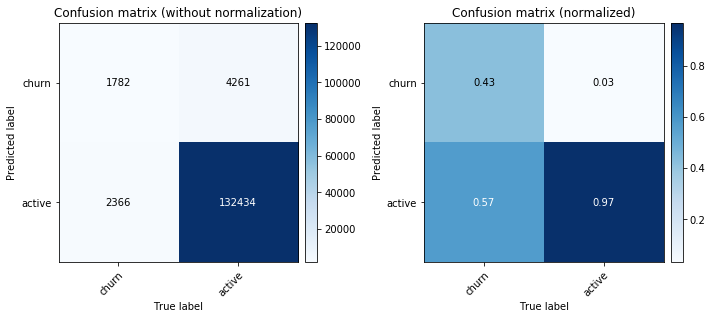

In [24]:
model = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
predict_test = model.predict(X_test)
predict_test_probas = model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()

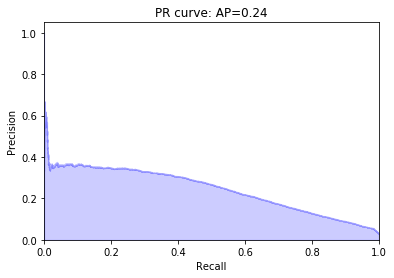

In [25]:
plot_PR_curve(y_test.values, predict_test, predict_test_probas)
plt.show()

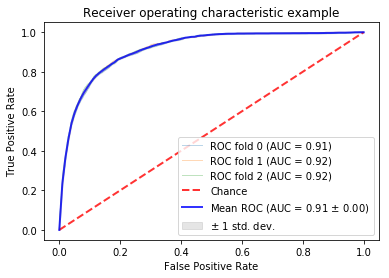

In [26]:
plot_ROC_curve(classifier=model, 
               X=X_test, 
               y=y_test.values, 
               n_folds=3)

In [27]:
import seaborn as sns

In [41]:
X_corr = pd.concat([pd.DataFrame(X_train_balanced, columns=X.columns), y_train_balanced], axis=1)

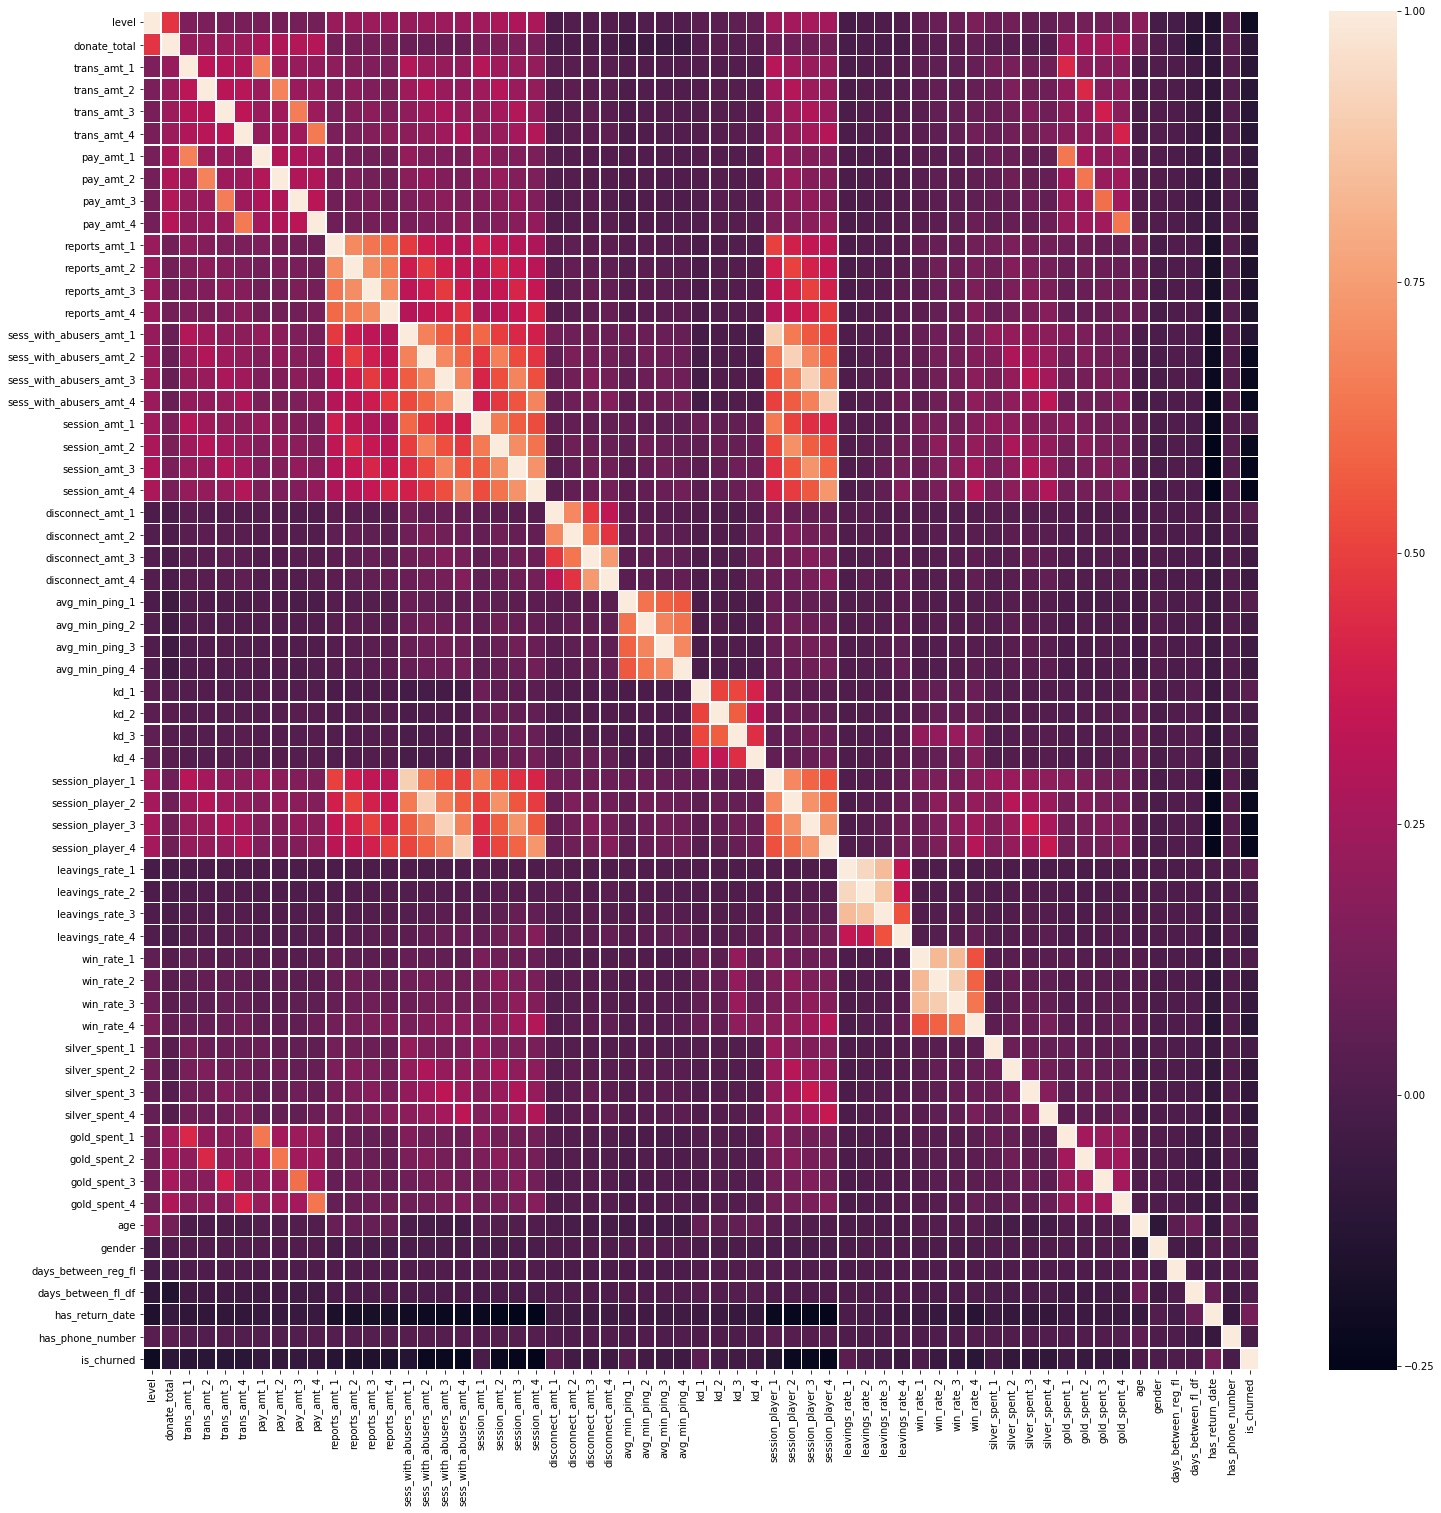

In [43]:
plt.figure(figsize=(25,25))
sns.heatmap(X_corr.corr().round(3), linewidths=.5)